In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
from tqdm import tqdm
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
config = f"""
dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv

seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

In [3]:
labels = pd.read_csv(os.path.join(CFG['dataset']['competition_dir'], 'train_events.csv'))

# 朝と夜の両方がそろってるものだけを残す
check = labels.groupby(["series_id", "night"])["step"].count().reset_index()
check["step"] = check["step"] == 2
check.rename(columns={"step": "safe"}, inplace=True)
labels = labels.merge(check, on=["series_id", "night"], how="left")
labels = labels[labels["safe"] == True]

labels.head()

,series_id,night,event,step,timestamp,safe
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400,True
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400,True
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400,True
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400,True
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400,True


In [4]:
train = pd.read_parquet(CFG["dataset"]["competition_dir"] + "/train_series.parquet")
train.head()

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0,2018-08-14T15:30:00-0400,2.6367,0.0217
1,038441c925bb,1,2018-08-14T15:30:05-0400,2.6368,0.0215
2,038441c925bb,2,2018-08-14T15:30:10-0400,2.6370,0.0216
3,038441c925bb,3,2018-08-14T15:30:15-0400,2.6368,0.0213
4,038441c925bb,4,2018-08-14T15:30:20-0400,2.6368,0.0215


In [5]:
def gaussian_kernel(length, sigma=3):
    x = np.ogrid[-length:length+1]
    h = np.exp(-(x**2) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h


for series_id, df in tqdm(train.groupby("series_id")):
    df = df.reset_index(drop=True)

    label_df = labels[labels["series_id"] == series_id][["step", "event"]]

    # 目的変数（起床時：1, 就寝時：0）
    df = df.merge(label_df, on="step", how="left")
    df["target"] = 0
    df.loc[df["event"] == "onset", "target"] = -1
    df.loc[df["event"] == "wakeup", "target"] = 1
    df["target"] = df["target"].cumsum() + 1

    # 目的変数（範囲内の閾値の個数）
    wakeup_steps = label_df[label_df["event"] == "wakeup"]["step"].values
    df.loc[df["step"].isin(wakeup_steps), "wakeup_target"] = 10
    df["wakeup_target"] = df["wakeup_target"].fillna(0)
    df["wakeup_target"] = np.convolve(df["wakeup_target"], gaussian_kernel(length=108, sigma=36), mode="same")
    
    onset_steps = label_df[label_df["event"] == "onset"]["step"].values
    df.loc[df["step"].isin(onset_steps), "onset_target"] = 10
    df["onset_target"] = df["onset_target"].fillna(0)
    df["onset_target"] = np.convolve(df["onset_target"], gaussian_kernel(length=108, sigma=36), mode="same")

    path = f"/kaggle/input/save_series_csv/csvs_gaussian/{series_id}.parquet"
    os.makedirs(os.path.dirname(path), exist_ok=True)
    df.to_parquet(path, index=False)

100%|██████████| 277/277 [01:08<00:00,  4.07it/s]


<AxesSubplot: >

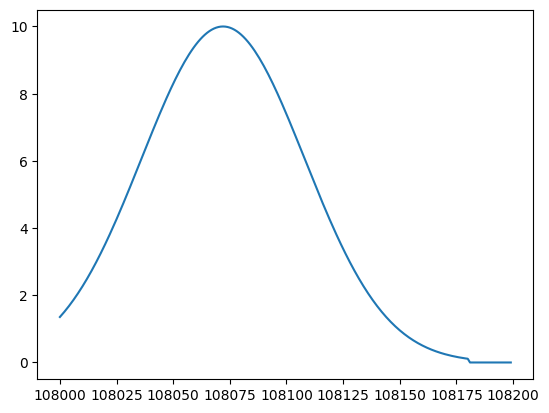

In [6]:
df["onset_target"][108000:108200].plot()